##### Supervisor Multi Agent workflow

- Supervisor is a multi-agent architecture where specialized agents ( here Research_Agent and Code_Generator ) are coordinated by a central supervisor agent. The supervisor agent controls all communication flow and task delegation, making decisions about which agent to invoke based on the current context and task requirements.

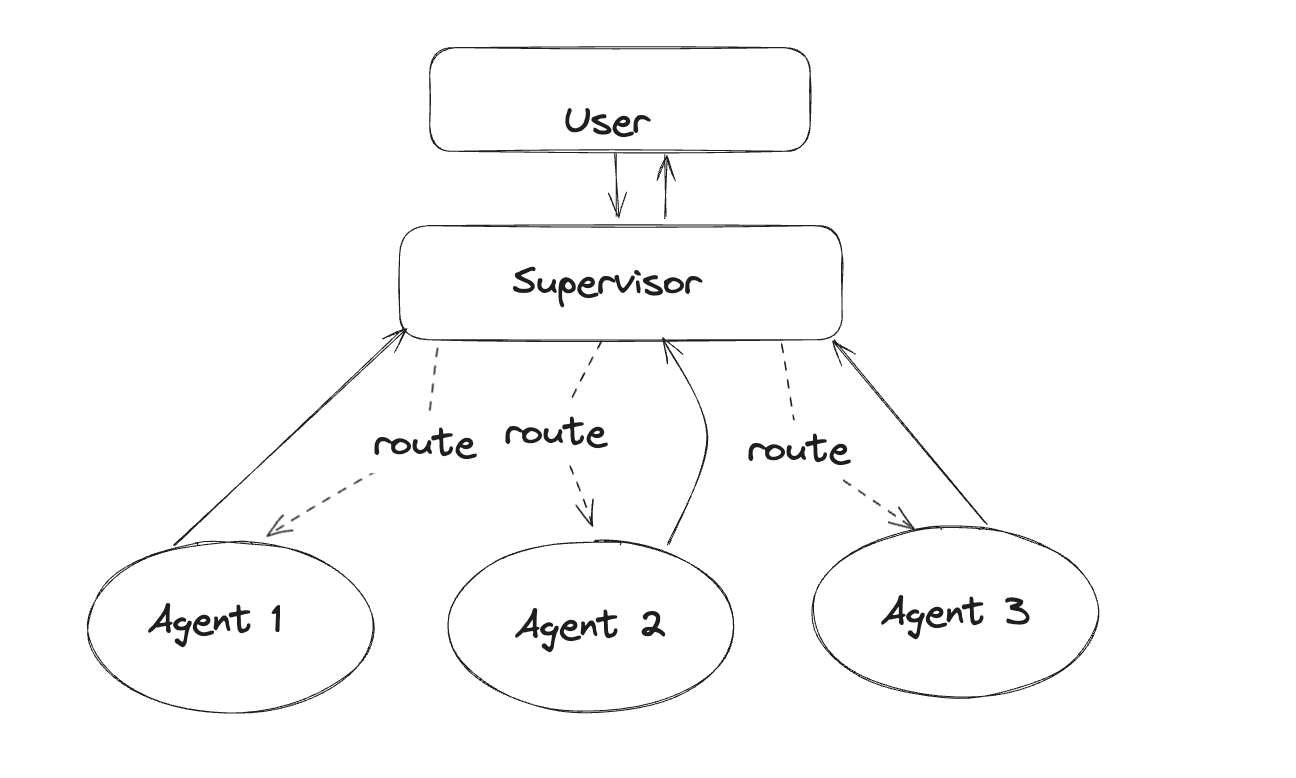

##### Loading necessary libraries

In [26]:
from langchain_core.tools import Tool,tool
from langchain_experimental.utilities import PythonREPL

from langgraph.graph import START,END,add_messages,StateGraph
from typing import TypedDict,Literal,Sequence,Annotated

from langchain_core.messages import BaseMessage,HumanMessage
from langgraph.types import Command

##### Loading Environment variables

In [27]:
from dotenv import load_dotenv

load_dotenv()

True

##### Setting up LLM

In [28]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="deepseek-r1-distill-llama-70b")
llm.invoke("hi")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 4, 'total_tokens': 18, 'completion_time': 0.071996147, 'prompt_time': 6.2869e-05, 'queue_time': 0.200436015, 'total_time': 0.072059016}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--a3c6a3f3-3819-4b9a-bce7-e76d8b4e3313-0', usage_metadata={'input_tokens': 4, 'output_tokens': 14, 'total_tokens': 18})

#### Defining Tools

##### Researcher Tool

In [29]:
from langchain_community.tools.tavily_search import TavilySearchResults

tanvily_tool=TavilySearchResults()

In [30]:
tanvily_tool.invoke("whats latest news in chicago on occassion of 4th of july 2025?")

[{'title': '4 killed, 30 hurt in shootings across Chicago during Fourth of July ...',
  'url': 'https://www.cbsnews.com/chicago/news/chicago-weekend-shootings-july-3-to-7/',
  'content': 'Watch CBS News\n\n# 4 killed, 30 hurt in shootings across Chicago during Fourth of July weekend, police say\n\nchicago\nJeramie  Bizzle\n\nUpdated on: July 5, 2025 / 5:16 PM CDT\n/ CBS Chicago\n\nAt least four people were killed and 30 others were wounded in shootings across Chicago during the Fourth of July weekend, according to police.\n\nThe ages of the victims range from 16 to 52.\n\n## Shootings from Thursday [...] #### Four men hurt in mass shooting in Marshall Square neighborhood\n\n \n\n#### 4 wounded in 2 shootings in East Chicago, Indiana\n\n©2025 CBS Broadcasting Inc. All Rights Reserved.',
  'score': 0.77199864},
 {'title': 'Chicago Fourth of July Events Guide',
  'url': 'https://www.choosechicago.com/articles/holidays/4th-of-july-in-chicago/',
  'content': 'Saturday, July 5 – Sunday, July

##### Coder Tool

In [31]:
repl=PythonREPL()

In [32]:
code="""
x=10
y=5
z=x+y
print(z)
"""

In [33]:
repl.run(code)

'15\n'

In [34]:
@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."], ):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )



#### Supervisor Multi-Agent workflow

In [35]:
members=["Researcher_Agent","Chart_Generator"]
options= members + ["FINISH"]

##### Defining Agent State

In [36]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],add_messages]
    next:str

#### Supervisor Agent

In [37]:
System_prompt=f"""
            You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
            Given the following user request, respond with the worker to act next. 
            Each worker will perform a task and respond with their results and status. 
            When finished, respond with FINISH."""
    

In [38]:
def make_system_prompt(instruction:str)->str:
    return  (f"You can  {instruction}")

In [39]:
class Router(TypedDict):
    next: Literal["Researcher_Agent","Chart_Generator",'FINISH']


In [40]:
messages = [{"role": "system", "content": System_prompt},] + ["hi"]

In [41]:
llm_with_structure_output=llm.with_structured_output(Router)

llm_with_structure_output.invoke(messages)

{'next': 'Researcher_Agent'}

In [42]:
def supervisor_agent(state:AgentState)->Command[Literal["Researcher_Agent","Chart_Generator","__end__"]]:
    print("enter supervisor\n")
    message=[{"role":"system","content":System_prompt}] + state["messages"]
    llm_with_schema=llm.with_structured_output(Router)
    result=llm_with_schema.invoke(message)
    print("\n", result)
    
    goto=result["next"]

    if goto=="FINISH":
        goto=END

    return Command(update={"next":goto},goto=goto)

##### 1. Researcher Agent

In [43]:
from langchain_core.prompts import PromptTemplate
from langchain.agents import create_react_agent
from langchain.prompts import PromptTemplate
from langchain.agents import create_react_agent
from langchain.agents.agent_types import AgentType
from langchain.tools.render import render_text_description

In [44]:
def researcher_agent(state: AgentState) -> Command[Literal["Supervisor_Agent"]]:
    model = llm
    tools = [tanvily_tool]
    state = {**state, "intermediate_steps": state.get("intermediate_steps", [])}

    # Define the base prompt
    base_prompt = PromptTemplate(
        input_variables=["input", "agent_scratchpad"],
        template="""
                    You can only do research. You are working with a chart generator colleague.

                    Available tools:
                    {tools}

                    User query:
                    {input}

                    Thoughts and actions:
                    {agent_scratchpad}
                            """
    )

 
    prompt = base_prompt.partial(
        tools=render_text_description(tools),
        tool_names=", ".join([tool.name for tool in tools])
    )

    
    react_agent = create_react_agent(llm=model, tools=tools, prompt=prompt)

    # Run agent
    result = react_agent.invoke(state)
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="Researcher_Agent")

    return Command(update={"messages": result["messages"]}, goto="Supervisor_Agent")


##### 2. Coder Agent

In [45]:
def chart_generator(state:AgentState)->Command[Literal["Supervisor_Agent"]]:
    state = {**state, "intermediate_steps": state.get("intermediate_steps", [])}

    model=llm
    tools=[python_repl_tool]
    prompt = PromptTemplate(
    input_variables=["input", "agent_scratchpad"],
    template="""
                You can only generate charts. You are working with a researcher colleague.

                Available tools:
                {tools}

                User query:
                {input}

                Thoughts and actions:
                {agent_scratchpad}
                """
                )
    
    prompt = base_prompt.partial(
        tools=render_text_description(tools),
        tool_names=", ".join([tool.name for tool in tools])
    )
    
    react_agent=create_react_agent(llm=model,tools=tools,prompt=prompt )
    result=react_agent.invoke(state)
    result["messages"][-1]=HumanMessage(content=result["messages"][-1].content,name="Chart_Generator")
    goto="Supervisor_Agent"
    return Command(update={"messages":result["messages"]},goto=goto)

#### Defining Workflow

In [46]:
graph=StateGraph(AgentState)

In [47]:
graph.add_node("Supervisor_Agent", supervisor_agent)
graph.add_node("Researcher_Agent",researcher_agent)
graph.add_node("Chart_Generator",chart_generator)

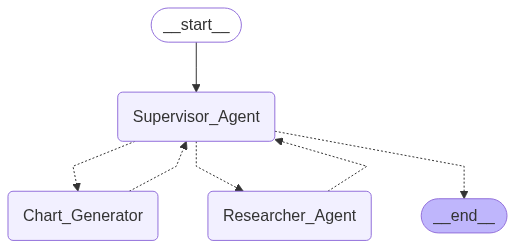

In [48]:
graph.add_edge(START,"Supervisor_Agent")
graph.compile()

In [49]:
agent=graph.compile()

In [50]:
agent.invoke({
    "messages": [
        {
            "role": "user",
            "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
        }
    ],
    "intermediate_steps": []
})


enter supervisor


 {'next': 'Researcher_Agent'}


KeyError: "Input to PromptTemplate is missing variables {'input'}.  Expected: ['agent_scratchpad', 'input'] Received: ['messages', 'next', 'intermediate_steps', 'agent_scratchpad']\nNote: if you intended {input} to be part of the string and not a variable, please escape it with double curly braces like: '{{input}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "